# Kelly Fomula

Due  August 26th by 10:00 am.

Yuan Yao (s2259521)

## 0. Setup

In [2]:
import os
from google.colab import drive

drive.mount('/content/drive')
os.chdir('drive/My Drive/Colab Notebooks/dissertation/material')
!ls

Mounted at /content/drive
data


In [1]:
import pandas as pd
import seaborn as sns
import random

# Data libraries
import numpy as np
import scipy
import scipy.stats as stats

# Plotting libraries
import matplotlib.pyplot as plt

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80


## 2. Empirical Study for Single Stock

### 2.1 Get data


1. The return rate on the three-month short term medium term government bond is taken as the risk-free rate. 
Source: https://www.chinabond.com.cn/cb/cn/zzsj/zzjgcp/cpxz/qxxz/zzgzqx/list_2.shtml

In [3]:
# Get data
total_r = pd.DataFrame()

for i in range(2002,2022):
  res = pd.read_excel(f'./data/{i}.xlsx')
  res = pd.DataFrame(res)
  total_r = pd.concat([total_r, res], axis=0)

# three-month short term medium term government bond
r = total_r[total_r['标准期限说明']=='3m'].reset_index(drop=True)

# data processing of risk-free rate
r = r[['日期','收益率(%)']]
r.columns=['date','annulized return(%)']
r['date'] = pd.to_datetime(r['date'])
r['weekly_rate'] = (1 + r['annulized return(%)']/100) ** (1 / 52)-1
r

/usr/local/lib/python3.7/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,date,annulized return(%),weekly_rate
0,2002-01-04,2.5312,0.000481
1,2002-01-07,2.5489,0.000484
2,2002-01-08,1.7235,0.000329
3,2002-01-09,1.6983,0.000324
4,2002-01-10,1.6942,0.000323
...,...,...,...
4992,2021-12-27,2.3210,0.000441
4993,2021-12-28,2.3213,0.000441
4994,2021-12-29,2.2801,0.000434
4995,2021-12-30,2.2101,0.000420


2. Select the data of 沪深300。

In [7]:
index_1 = pd.read_csv('./data/000300.csv',index_col=0)
index_1['trade_date'] = pd.to_datetime(index_1['trade_date'],format = '%Y%m%d')
index_1


,ts_code,trade_date,close
853,000300.SH,2005-04-08,1003.4500
852,000300.SH,2005-04-15,974.0800
851,000300.SH,2005-04-22,939.1000
850,000300.SH,2005-04-29,932.4000
849,000300.SH,2005-05-13,887.5400
...,...,...,...
4,000300.SH,2021-12-03,4901.0175
3,000300.SH,2021-12-10,5055.1172
2,000300.SH,2021-12-17,4954.7599
1,000300.SH,2021-12-24,4921.3449


### 2.2 Rolling optimization

In [293]:
index_1['returns'] = index_1['close'] / index_1['close'].shift(1)
index_1['log_returns'] = np.log(index_1['returns'])
index_1_new = index_1.set_index('trade_date').join(r[['weekly_rate','date']].set_index('date'))
index_1_new['excess_rate'] = index_1_new['log_returns'] - index_1_new['weekly_rate']
index_1_new

,ts_code,close,returns,log_returns,weekly_rate,excess_rate
trade_date,,,,,,
2005-04-08,000300.SH,1003.4500,NaN,NaN,0.000471,NaN
2005-04-15,000300.SH,974.0800,0.970731,-0.029706,0.000444,-0.030150
2005-04-22,000300.SH,939.1000,0.964089,-0.036571,0.000428,-0.037000
2005-04-29,000300.SH,932.4000,0.992866,-0.007160,0.000467,-0.007628
2005-05-13,000300.SH,887.5400,0.951888,-0.049308,0.000453,-0.049762
...,...,...,...,...,...,...
2021-12-03,000300.SH,4901.0175,1.008414,0.008378,0.000435,0.007944
2021-12-10,000300.SH,5055.1172,1.031442,0.030958,0.000441,0.030517
2021-12-17,000300.SH,4954.7599,0.980147,-0.020052,0.000443,-0.020496


In [311]:
windows = 260
periods = 1
index_1_new['mean'] = index_1_new['excess_rate'].rolling(windows).mean()
index_1_new['std'] = index_1_new['excess_rate'].rolling(windows).std()

index_1_new['kelly_fraction'] = np.nan
for i in range(windows,len(index_1_new),periods):
    mean = index_1_new['mean'].iloc[i]
    std = index_1_new['std'].iloc[i]
    kelly = mean / (mean**2 + std**2)
    for j in range(periods):
      if i+j < len(index_1_new):
        index_1_new['kelly_fraction'].iloc[i+j] = kelly

wealth_0 = 100.0
index_1_new['wealth'] = wealth_0
for i in range(windows,len(index_1_new)):
  f = index_1_new['kelly_fraction'][i]
  index_1_new['wealth'][i] = index_1_new['wealth'][i-1]*(f*index_1_new['returns'][i]+(1-f)*(1+index_1_new['weekly_rate'][i]))

weeks = len(index_1_new)-windows
hold_return = np.log((index_1_new['close'][weeks-1]/index_1_new['close'][windows-1])**(1/weeks))
kelly_return = np.log((index_1_new['wealth'][weeks-1]/wealth_0)**(1/weeks))
print(f'The geometric average rate of return under buy-and-hold strategy is {hold_return}.')
print(f'The geometric average rate of return under Kelly strategy is {kelly_return}.')

The geometric average rate of return under buy-and-hold strategy is 0.00040640154630386334.
The geometric average rate of return under Kelly strategy is -0.00029378908308721894.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


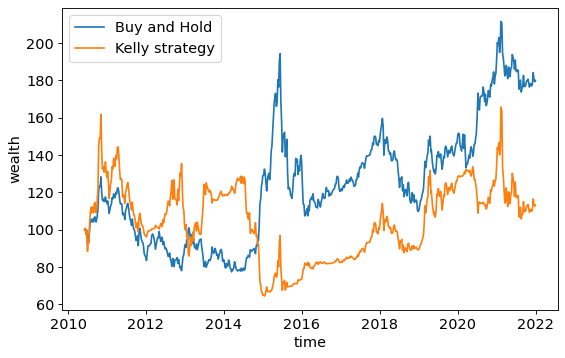

In [312]:
plt.plot(index_1_new['close'][windows-1:]/index_1_new['close'][windows-1]*index_1_new['wealth'][windows-1],label='Buy and Hold')
plt.plot(index_1_new['wealth'][windows-1:],label='Kelly strategy')
plt.xlabel('time',fontsize=13)
plt.ylabel('wealth',fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=13)


In [319]:
windows = 260
periods = 1
index_1_new['mean'] = index_1_new['excess_rate'].rolling(windows).mean()
index_1_new['std'] = index_1_new['excess_rate'].rolling(windows).std()

for k in range(1,10):
  index_1_new['kelly_fraction'] = np.nan
  for i in range(windows,len(index_1_new),periods):
      mean = index_1_new['mean'].iloc[i]
      std = index_1_new['std'].iloc[i]
      kelly = mean / (mean**2 + std**2)
      if kelly > k:
        kelly = k
      if kelly < -k:
        kelly = -k
      for j in range(periods):
        if i+j < len(index_1_new):
          index_1_new['kelly_fraction'].iloc[i+j] = kelly

  wealth_0 = 100.0
  index_1_new['wealth'] = wealth_0
  for i in range(windows,len(index_1_new)):
    f = index_1_new['kelly_fraction'][i]
    index_1_new['wealth'][i] = index_1_new['wealth'][i-1]*(f*index_1_new['returns'][i]+(1-f)*(1+index_1_new['weekly_rate'][i]))

  weeks = len(index_1_new)-windows
  hold_return = np.log((index_1_new['close'][weeks-1]/index_1_new['close'][0])**(1/weeks))
  kelly_return = np.log((index_1_new['wealth'][weeks-1]/wealth_0)**(1/weeks))
  print(f'bound = {k}:The geometric average rate of return under buy-and-hold strategy is {hold_return}.')
  print(f'bound = {k}: The geometric average rate of return under Kelly strategy is {kelly_return}.')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


bound = 1:The geometric average rate of return under buy-and-hold strategy is 0.0021001974480576425.
bound = 1: The geometric average rate of return under Kelly strategy is -0.00018406175186672988.
bound = 2:The geometric average rate of return under buy-and-hold strategy is 0.0021001974480576425.
bound = 2: The geometric average rate of return under Kelly strategy is -0.00030039589345072894.
bound = 3:The geometric average rate of return under buy-and-hold strategy is 0.0021001974480576425.
bound = 3: The geometric average rate of return under Kelly strategy is -0.00029378908308721894.
bound = 4:The geometric average rate of return under buy-and-hold strategy is 0.0021001974480576425.
bound = 4: The geometric average rate of return under Kelly strategy is -0.00029378908308721894.
bound = 5:The geometric average rate of return under buy-and-hold strategy is 0.0021001974480576425.
bound = 5: The geometric average rate of return under Kelly strategy is -0.00029378908308721894.
bound = 6:

In [313]:
windows = 52
periods = 1
index_1_new['mean'] = index_1_new['excess_rate'].rolling(windows).mean()
index_1_new['std'] = index_1_new['excess_rate'].rolling(windows).std()

index_1_new['kelly_fraction'] = np.nan
for i in range(windows,len(index_1_new),periods):
    mean = index_1_new['mean'].iloc[i]
    std = index_1_new['std'].iloc[i]
    kelly = mean / (mean**2 + std**2)
    # if kelly > 1:
    #   kelly = 1
    # if kelly < -1:
    #   kelly = -1
    for j in range(periods):
      if i+j < len(index_1_new):
        index_1_new['kelly_fraction'].iloc[i+j] = kelly

wealth_0 = 100.0
index_1_new['wealth'] = wealth_0
for i in range(windows,len(index_1_new)):
  f = index_1_new['kelly_fraction'][i]
  index_1_new['wealth'][i] = index_1_new['wealth'][i-1]*(f*index_1_new['returns'][i]+(1-f)*(1+index_1_new['weekly_rate'][i]))

weeks = len(index_1_new)-windows
hold_return = np.log((index_1_new['close'][weeks-1]/index_1_new['close'][0])**(1/weeks))
kelly_return = np.log((index_1_new['wealth'][weeks-1]/wealth_0)**(1/weeks))
print(f'The geometric average rate of return under buy-and-hold strategy is {hold_return}.')
print(f'The geometric average rate of return under Kelly strategy is {kelly_return}.')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


The geometric average rate of return under buy-and-hold strategy is 0.002054093610530869.
The geometric average rate of return under Kelly strategy is nan.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars


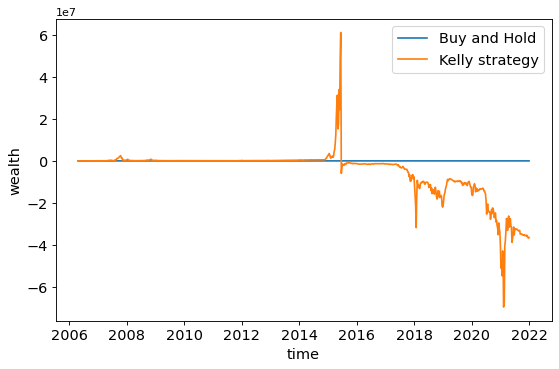

In [314]:
plt.plot(index_1_new['close'][windows-1:]/index_1_new['close'][windows-1]*index_1_new['wealth'][windows-1],label='Buy and Hold')
plt.plot(index_1_new['wealth'][windows-1:],label='Kelly strategy')
plt.xlabel('time',fontsize=13)
plt.ylabel('wealth',fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=13)

In [318]:
windows = 52
periods = 1
index_1_new['mean'] = index_1_new['excess_rate'].rolling(windows).mean()
index_1_new['std'] = index_1_new['excess_rate'].rolling(windows).std()

for k in range(1,10):
  index_1_new['kelly_fraction'] = np.nan
  for i in range(windows,len(index_1_new),periods):
      mean = index_1_new['mean'].iloc[i]
      std = index_1_new['std'].iloc[i]
      kelly = mean / (mean**2 + std**2)
      if kelly > k:
        kelly = k
      if kelly < -k:
        kelly = -k
      for j in range(periods):
        if i+j < len(index_1_new):
          index_1_new['kelly_fraction'].iloc[i+j] = kelly

  wealth_0 = 100.0
  index_1_new['wealth'] = wealth_0
  for i in range(windows,len(index_1_new)):
    f = index_1_new['kelly_fraction'][i]
    index_1_new['wealth'][i] = index_1_new['wealth'][i-1]*(f*index_1_new['returns'][i]+(1-f)*(1+index_1_new['weekly_rate'][i]))

  weeks = len(index_1_new)-windows
  hold_return = np.log((index_1_new['close'][weeks-1]/index_1_new['close'][0])**(1/weeks))
  kelly_return = np.log((index_1_new['wealth'][weeks-1]/wealth_0)**(1/weeks))
  print(f'bound = {k}: The geometric average rate of return under buy-and-hold strategy is {hold_return}.')
  print(f'bound = {k}: The geometric average rate of return under Kelly strategy is {kelly_return}.')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


bound = 1:The geometric average rate of return under buy-and-hold strategy is 0.002054093610530869.
bound = 1: The geometric average rate of return under Kelly strategy is 0.004128033778698901.
bound = 2:The geometric average rate of return under buy-and-hold strategy is 0.002054093610530869.
bound = 2: The geometric average rate of return under Kelly strategy is 0.0063879439525210205.
bound = 3:The geometric average rate of return under buy-and-hold strategy is 0.002054093610530869.
bound = 3: The geometric average rate of return under Kelly strategy is 0.007704771165579527.
bound = 4:The geometric average rate of return under buy-and-hold strategy is 0.002054093610530869.
bound = 4: The geometric average rate of return under Kelly strategy is 0.008849421160450148.
bound = 5:The geometric average rate of return under buy-and-hold strategy is 0.002054093610530869.
bound = 5: The geometric average rate of return under Kelly strategy is 0.010075215340888176.
bound = 6:The geometric avera

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars


bound = 8:The geometric average rate of return under buy-and-hold strategy is 0.002054093610530869.
bound = 8: The geometric average rate of return under Kelly strategy is nan.
bound = 9:The geometric average rate of return under buy-and-hold strategy is 0.002054093610530869.
bound = 9: The geometric average rate of return under Kelly strategy is nan.


In [320]:
index_1['returns'] = index_1['close'] / index_1['close'].shift(1)
index_1['log_returns'] = np.log(index_1['returns'])
index_1_new = index_1.set_index('trade_date').join(r[['weekly_rate','date']].set_index('date'))
index_1_new

windows = 260
a = 0.9
para = 0
index_1_new['mean'] = np.nan
index_1_new['var'] = np.nan

for h in range(1,windows+1):
  para += a**h

for i in range(windows+1,len(index_1_new)):
  ema = 0
  emvar = 0
  for h in range(1,windows+1):
    ema += index_1_new['log_returns'][i-h]*(a**h)
  index_1_new['mean'][i] = ema/para
  for h in range(1,windows+1):
    emvar += ((index_1_new['log_returns'][i-h]-index_1_new['mean'][i])**2)*(a**h)
  index_1_new['var'][i] = emvar/para

index_1_new['kelly_fraction']=np.nan
for i in range(windows+1,len(index_1_new)):
    mean = index_1_new['mean'].iloc[i]-index_1_new['weekly_rate'].iloc[i]
    var = index_1_new['var'].iloc[i]
    kelly = mean / (mean**2 + var)
    if kelly > 1:
      kelly = 1
    if kelly < -1:
      kelly = -1
    index_1_new['kelly_fraction'][i] = kelly

wealth_0 = 100.0
index_1_new['wealth'] = wealth_0
for i in range(windows+1,len(index_1_new)):
  f = index_1_new['kelly_fraction'][i]
  index_1_new['wealth'][i] = index_1_new['wealth'][i-1]*(f*index_1_new['returns'][i]+(1-f)*(1+index_1_new['weekly_rate'][i]))

weeks = len(index_1_new)
hold_return = np.log((index_1_new['close'][weeks-1]/index_1_new['close'][0])**(1/weeks))
kelly_return = np.log((index_1_new['wealth'][weeks-1]/wealth_0)**(1/weeks))
print(f'The geometric average rate of return under buy-and-hold strategy is {hold_return}.')
print(f'The geometric average rate of return under Kelly strategy is {kelly_return}.')



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to b

The geometric average rate of return under buy-and-hold strategy is 0.0018665068299107725.
The geometric average rate of return under Kelly strategy is 0.0005704667815540278.


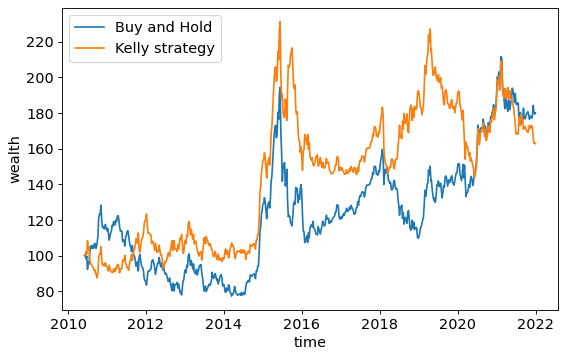

In [321]:
plt.plot(index_1_new['close'][windows-1:]/index_1_new['close'][windows-1]*index_1_new['wealth'][windows-1],label='Buy and Hold')
plt.plot(index_1_new['wealth'][windows-1:],label='Kelly strategy')
plt.xlabel('time',fontsize=13)
plt.ylabel('wealth',fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=13)

In [331]:
index_1['returns'] = index_1['close'] / index_1['close'].shift(1)
index_1['log_returns'] = np.log(index_1['returns'])
index_1_new = index_1.set_index('trade_date').join(r[['weekly_rate','date']].set_index('date'))
index_1_new

windows = 52
a = 0.9
para = 0
index_1_new['mean'] = np.nan
index_1_new['var'] = np.nan

for h in range(1,windows+1):
  para += a**h

for i in range(windows+1,len(index_1_new)):
  ema = 0
  emvar = 0
  for h in range(1,windows+1):
    ema += index_1_new['log_returns'][i-h]*(a**h)
  index_1_new['mean'][i] = ema/para
  for h in range(1,windows+1):
    emvar += ((index_1_new['log_returns'][i-h]-index_1_new['mean'][i])**2)*(a**h)
  index_1_new['var'][i] = emvar/para

for k in range(1,7):
  index_1_new['kelly_fraction']=np.nan
  for i in range(windows+1,len(index_1_new)):
      mean = index_1_new['mean'].iloc[i]-index_1_new['weekly_rate'].iloc[i]
      var = index_1_new['var'].iloc[i]
      kelly = mean / (mean**2 + var)
      if kelly > k:
        kelly = k
      if kelly < -k:
        kelly = -k
      index_1_new['kelly_fraction'][i] = kelly

  wealth_0 = 100.0
  index_1_new['wealth'] = wealth_0
  for i in range(windows+1,len(index_1_new)):
    f = index_1_new['kelly_fraction'][i]
    index_1_new['wealth'][i] = index_1_new['wealth'][i-1]*(f*index_1_new['returns'][i]+(1-f)*(1+index_1_new['weekly_rate'][i]))

  weeks = len(index_1_new)-windows
  hold_return = np.log((index_1_new['close'][weeks-1]/index_1_new['close'][0])**(1/weeks))
  kelly_return = np.log((index_1_new['wealth'][weeks-1]/wealth_0)**(1/weeks))
  print(f'bound = {k}: The geometric average rate of return under buy-and-hold strategy is {hold_return}.')
  print(f'bound = {k}: The geometric average rate of return under Kelly strategy is {kelly_return}.')



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to b

bound = 1: The geometric average rate of return under buy-and-hold strategy is 0.002054093610530869.
bound = 1: The geometric average rate of return under Kelly strategy is 0.003570234813727922.
bound = 2: The geometric average rate of return under buy-and-hold strategy is 0.002054093610530869.
bound = 2: The geometric average rate of return under Kelly strategy is 0.005423689293816482.
bound = 3: The geometric average rate of return under buy-and-hold strategy is 0.002054093610530869.
bound = 3: The geometric average rate of return under Kelly strategy is 0.006683194824508742.
bound = 4: The geometric average rate of return under buy-and-hold strategy is 0.002054093610530869.
bound = 4: The geometric average rate of return under Kelly strategy is 0.0068655484647467775.
bound = 5: The geometric average rate of return under buy-and-hold strategy is 0.002054093610530869.
bound = 5: The geometric average rate of return under Kelly strategy is 0.005799882492910958.
bound = 6: The geometric